# Weights exfiltration

In our adversarial images notebook, we explored a permissioned, or white-box attack, where we have access to the model. 

Here, we will try various black-box, or unpermissioned attacks based on scenarios where we cannot access the underlying model (eg via an API service).

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import seaborn as sns

To simulate an API, we will have a wrapped ResNet18 model that can only receive inputs and get predictions

In [7]:
class VictimModel:
    """Simulates a black-box API - we can only send inputs and get predictions back."""
    
    def __init__(self, model_name="resnet18"):
        print(f"Loading victim model: {model_name}")
        self.model = models.resnet18(weights=True)
        self.model.eval()
        self.queries = 0
        self.max_queries = 10000
        
    def predict(self, x):
        """The only interface we have - like calling an API endpoint."""
        if self.queries >= self.max_queries:
            raise Exception("API quota exceeded! (This is why attacks are expensive)")
        
        self.queries += 1
        with torch.no_grad():
            if x.dim() == 3:
                x = x.unsqueeze(0)
            logits = self.model(x)
            probs = F.softmax(logits, dim=1)
            return probs.squeeze()

We will try three attacks in our `BlacBoxAttacker` class

* Decision boundary probing -- consider this the reconnaissance phase
* Adversarial example crafting -- finding exploitations
* Model extraction -- knowledge / IP theft

In [45]:
class BlackBoxAttacker:
    """The attacker - trying to steal secrets from the black box."""
    
    def __init__(self, victim_model):
        self.victim = victim_model

# Initialize our attack scenario
victim = VictimModel()
attacker = BlackBoxAttacker(victim)

# Generate test images for our attacks
print("\nGenerating test images...")
# img1 = torch.randn(3, 224, 224) * 0.8
# img2 = torch.randn(3, 224, 224) * 0.8
img1_path = "images/siamese_cat.jpeg"
img2_path = "images/saint_bernard.jpeg"

# Load and preprocess the actual images
from PIL import Image
import torchvision.transforms as transforms

# Standard ImageNet preprocessing for ResNet18
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

# Load images
img1 = preprocess(Image.open(img1_path).convert('RGB')).unsqueeze(0)
img2 = preprocess(Image.open(img2_path).convert('RGB')).unsqueeze(0)

print("Setup complete! Ready to begin attacks...")
print(f"Starting query count: {victim.queries}/{victim.max_queries}")

Loading victim model: resnet18

Generating test images...
Setup complete! Ready to begin attacks...
Starting query count: 0/10000


### Probing classification boundaries

Finding the line at which classifications are split can be valuable information about the model's behaviour. In this cell, we take the following steps:

* Create a straight line between two input images in the pixel space
* Sample points along the line, querying the target model to elicit its class prediction, and its confidence in that prediction
* Detect the exact locations where the model shifts its classification

In [46]:
def probe_decision_boundary(self, img1, img2, steps=20):
    """Find where the model changes its mind by interpolating between images."""
    print("\nATTACK 1: Decision Boundary Reconnaissance")
    print("Interpolating between two inputs to find decision boundaries...")


    
    # Get predictions for two starting points
    # This tells us which classes the model assigns to each endpoint
    pred1 = torch.argmax(self.victim.predict(img1)).item()
    pred2 = torch.argmax(self.victim.predict(img2)).item()
    
    # Initialize storage for our reconnaissance data
    boundary_data = []
    decision_changes = [] # this will track when the model changes its mind
    
    # Walk along the straight line between img1 and img2 in pixel space
    # Think of this as drawing a line through high-dimensional space (3×224×224 = ~150k dimensions!)
    for i in range(steps + 1):
        # alpha controls our position along the line
        # eg α=0 → pure img2, α=1 → pure img1, α=0.5 → halfway blend
        alpha = i / steps
    
        # Linear interpolation: create a weighted blend of the two images
        # This is like morphing between two photos, pixel by pixel
        # interpolated[pixel] = α × img1[pixel] + (1-α) × img2[pixel]
        interpolated = alpha * img1 + (1 - alpha) * img2
    
        # Query the mock API with interpolated image
        probs = self.victim.predict(interpolated)
        pred_class = torch.argmax(probs).item() # Which class has highest probability?
        confidence = torch.max(probs).item() # How confident is the model?
        
        boundary_data.append({
            'position': alpha,
            'prediction': pred_class,
            'confidence': confidence
        })
        
        # Detect decision boundary crossings
        # This should reveal the point in the input space where the model's
        # decision changes. This is how we gain x-ray vision into the
        # internal structure of the model without access to weights or gradients
        if i > 0 and boundary_data[i-1]['prediction'] != pred_class:
            decision_changes.append(alpha)

        print(boundary_data)
    
    print(f"   Found {len(decision_changes)} decision boundary crossings!")
    print(f"   Queries used: {len(boundary_data)} | Total: {self.victim.queries}")
    
    return boundary_data, decision_changes

In [47]:
boundary_data, crossings = probe_decision_boundary(attacker, img1, img2)


ATTACK 1: Decision Boundary Reconnaissance
Interpolating between two inputs to find decision boundaries...
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}, {'position': 0.1, 'prediction': 247, 'confidence': 0.9728532433509827}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}, {'position': 0.1, 'prediction': 247, 'confidence': 0.9728532433509827}, {'position': 0.15, 'prediction': 247, 'confidence': 0.9689539074897766}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}, {'position': 0.1, 'pre

We can see from these results:

* Class 247 (Siamese cat) at α=0 → α=0.3 (high confidence ~98% → 79%)
* Decision boundary crossings at α=0.35 and α=0.4:

    α=0.35: Brief switch to Class 195 (low confidence 37%)

    α=0.4: Switches to Class 284 (Saint Bernard) and stays there


The model is most vulnerable around α=0.35 (confidence drops to 37%)

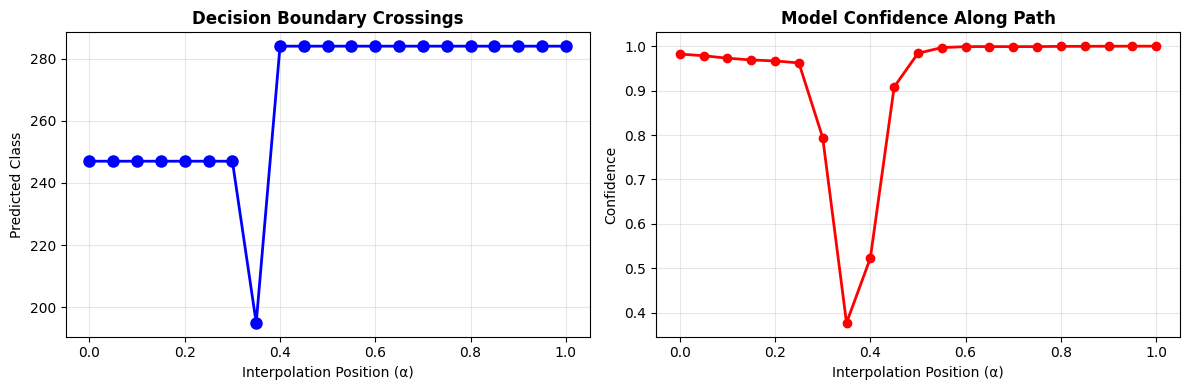

In [48]:
def plot_boundary_results(boundary_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    positions = [d['position'] for d in boundary_data]
    predictions = [d['prediction'] for d in boundary_data]
    confidences = [d['confidence'] for d in boundary_data]
    
    # Plot 1: Decision changes
    ax1.plot(positions, predictions, 'bo-', markersize=8, linewidth=2)
    ax1.set_title('Decision Boundary Crossings', fontweight='bold')
    ax1.set_xlabel('Interpolation Position (α)')
    ax1.set_ylabel('Predicted Class')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Confidence changes
    ax2.plot(positions, confidences, 'ro-', markersize=6, linewidth=2)
    ax2.set_title('Model Confidence Along Path', fontweight='bold')
    ax2.set_xlabel('Interpolation Position (α)')
    ax2.set_ylabel('Confidence')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_boundary_results(boundary_data)

We can see from the visualisations that the model has simple decision boundaries.

### Crafting adversarial examples

Now we can use the reconnaissance data to craft adversarial examples! In the following cell, we

* take the boundary crossing points found (α=0.35, α=0.4 or similar)
* calculate the direction vectors pointing toward those vulnerable regions
* create 'smart' perturbation directions

This is a more targeted approach to the fast gradient sign method, which creates random noise.

In [50]:
def craft_adversarial_example(self, base_img, target_class, boundary_data, img1, img2, max_iters=200):
    """Create an adversarial example using boundary-guided optimization."""
    print(f"\nATTACK 2: Boundary-Guided Adversarial Example Generation")
    print(f"   Trying to fool model into predicting class {target_class}...")
    
    current_img = base_img.clone()
    original_pred = torch.argmax(self.victim.predict(base_img)).item()
    
    print(f"   Original prediction: Class {original_pred}")
    
    # Extract boundary intelligence from reconnaissance
    decision_changes = []
    vulnerable_regions = []
    
    for i in range(1, len(boundary_data)):
        if boundary_data[i-1]['prediction'] != boundary_data[i]['prediction']:
            change_point = boundary_data[i]['position']
            decision_changes.append(change_point)
            print(f"   Using boundary crossing at α={change_point:.2f}")
            
        # Find regions with low confidence (vulnerable spots)
        if boundary_data[i]['confidence'] < 0.5:
            vulnerable_regions.append(boundary_data[i]['position'])
            print(f"   Found vulnerable region at α={boundary_data[i]['position']:.2f} (confidence: {boundary_data[i]['confidence']:.3f})")
    
    # Calculate direction vectors toward boundary crossings
    boundary_directions = []
    for alpha in decision_changes + vulnerable_regions:
        # Direction from base_img toward the boundary crossing point
        boundary_point = alpha * img1 + (1 - alpha) * img2
        direction = boundary_point - base_img
        direction = direction / torch.norm(direction)  # Normalize
        boundary_directions.append(direction)
    
    print(f"   Computed {len(boundary_directions)} boundary-guided directions")
    
    step_size = 0.01  # Smaller steps for more precision
    attack_history = []
    
    for iteration in range(max_iters):
        best_perturbation = None
        best_target_prob = -1
        
        # Phase 1: Try boundary-guided perturbations (70% of attempts)
        for direction in boundary_directions:
            for scale in [0.5, 1.0, 1.5]:  # Different magnitudes
                perturbation = direction * step_size * scale
                perturbed = torch.clamp(current_img + perturbation, -2, 2)
                
                probs = self.victim.predict(perturbed)
                target_prob = probs[target_class].item()
                
                if target_prob > best_target_prob:
                    best_target_prob = target_prob
                    best_perturbation = perturbation
        
        # Phase 2: Random exploration (30% of attempts) for diversity
        for _ in range(3):
            noise = torch.randn_like(current_img) * step_size
            perturbed = torch.clamp(current_img + noise, -2, 2)
            
            probs = self.victim.predict(perturbed)
            target_prob = probs[target_class].item()
            
            if target_prob > best_target_prob:
                best_target_prob = target_prob
                best_perturbation = noise
        
        # Apply best perturbation
        if best_perturbation is not None:
            current_img = torch.clamp(current_img + best_perturbation, -2, 2)
            current_pred = torch.argmax(self.victim.predict(current_img)).item()
            
            attack_history.append({
                'iteration': iteration,
                'target_probability': best_target_prob,
                'prediction': current_pred,
                'perturbation_norm': torch.norm(current_img - base_img).item()
            })
            
            # Success condition
            if current_pred == target_class:
                print(f"   Success! Adversarial example found at iteration {iteration}")
                print(f"   Leveraged boundary intelligence to reduce attack queries!")
                print(f"   Perturbation magnitude: {attack_history[-1]['perturbation_norm']:.4f}")
                break
            
            # Progress update
            if iteration % 20 == 0:
                print(f"   Iteration {iteration}: Target prob = {best_target_prob:.3f}, Current pred = {current_pred}")
    
    final_pred = torch.argmax(self.victim.predict(current_img)).item()
    success = final_pred == target_class
    
    if not success:
        print(f"   Attack failed. Final prediction: Class {final_pred}")
        print(f"   Best target probability achieved: {max([h['target_probability'] for h in attack_history]):.3f}")
    
    # Calculate total queries (boundary reconnaissance + attack phases)
    estimated_queries = len(boundary_directions) * 3 + len(attack_history) * 3
    print(f"   Attack queries used: ~{estimated_queries} | Total: {self.victim.queries}")
    
    return {
        'adversarial_image': current_img,
        'original_image': base_img,
        'success': success,
        'history': attack_history,
        'boundary_directions_used': len(boundary_directions)
    }

In [52]:
boundary_data, crossings = probe_decision_boundary(
    attacker,
    img1, 
    img2
)

result = craft_adversarial_example(
    attacker,
    base_img=img1,  # Start with the cat image
    target_class=284,  # Try to make it predict "Saint Bernard" 
    boundary_data=boundary_data,
    img1=img1, 
    img2=img2
)


ATTACK 1: Decision Boundary Reconnaissance
Interpolating between two inputs to find decision boundaries...
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}, {'position': 0.1, 'prediction': 247, 'confidence': 0.9728532433509827}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}, {'position': 0.1, 'prediction': 247, 'confidence': 0.9728532433509827}, {'position': 0.15, 'prediction': 247, 'confidence': 0.9689539074897766}]
[{'position': 0.0, 'prediction': 247, 'confidence': 0.9821649789810181}, {'position': 0.05, 'prediction': 247, 'confidence': 0.978404700756073}, {'position': 0.1, 'pre

In [56]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def visualize_adversarial_attack(result, boundary_data, img1, img2, victim_model):
    """
    Visualize the adversarial attack results with original images, 
    adversarial example, and classification results.
    """
    
    # ImageNet class names (you can expand this or use a proper mapping)
    imagenet_classes = {
        247: "Siamese Cat",
        284: "Saint Bernard", 
        195: "Border Terrier"  # The intermediate class we saw
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Boundary-Guided Adversarial Attack Results', fontsize=16, fontweight='bold')
    
    # Helper function to denormalize images for display
    def denormalize_image(tensor_img):
        # Reverse ImageNet normalization
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        denorm = tensor_img * std + mean
        denorm = torch.clamp(denorm, 0, 1)
        return denorm.squeeze(0).permute(1, 2, 0).cpu().numpy()
    
    def get_prediction_info(img, model):
        with torch.no_grad():
            probs = model.predict(img)
            pred_class = torch.argmax(probs).item()
            confidence = torch.max(probs).item()
            return pred_class, confidence
    
    # Top row: Original images and adversarial result
    
    # Original Image 1 (Cat)
    pred1, conf1 = get_prediction_info(img1, victim_model)
    axes[0, 0].imshow(denormalize_image(img1))
    axes[0, 0].set_title(f'Original: {imagenet_classes.get(pred1, f"Class {pred1}")}\nConfidence: {conf1:.3f}', 
                        fontsize=12, color='green', fontweight='bold')
    axes[0, 0].axis('off')
    
    # Original Image 2 (Dog)  
    pred2, conf2 = get_prediction_info(img2, victim_model)
    axes[0, 1].imshow(denormalize_image(img2))
    axes[0, 1].set_title(f'Original: {imagenet_classes.get(pred2, f"Class {pred2}")}\nConfidence: {conf2:.3f}', 
                        fontsize=12, color='green', fontweight='bold')
    axes[0, 1].axis('off')
    
    # Adversarial Example
    adv_pred, adv_conf = get_prediction_info(result['adversarial_image'], victim_model)
    orig_pred, orig_conf = get_prediction_info(result['original_image'], victim_model)
    
    axes[0, 2].imshow(denormalize_image(result['adversarial_image']))
    
    if result['success']:
        title_color = 'red'
        title = f'\nNow predicts: {imagenet_classes.get(adv_pred, f"Class {adv_pred}")}\nConfidence: {adv_conf:.3f}'
    else:
        title_color = 'orange'  
        title = f'Attack Failed\nStill predicts: {imagenet_classes.get(adv_pred, f"Class {adv_pred}")}\nConfidence: {adv_conf:.3f}'
    
    axes[0, 2].set_title(title, fontsize=12, color=title_color, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Bottom row: Analysis plots
    
    # Perturbation visualization (difference between original and adversarial)
    perturbation = result['adversarial_image'] - result['original_image'] 
    pert_magnitude = torch.norm(perturbation).item()
    
    # Scale perturbation for visualization
    pert_vis = perturbation.squeeze(0).permute(1, 2, 0).cpu().numpy()
    pert_vis = (pert_vis - pert_vis.min()) / (pert_vis.max() - pert_vis.min())
    
    axes[1, 0].imshow(pert_vis)
    axes[1, 0].set_title(f'Perturbation Applied\nMagnitude: {pert_magnitude:.4f}', 
                        fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    # Decision boundary crossing visualization
    positions = [bd['position'] for bd in boundary_data]
    predictions = [bd['prediction'] for bd in boundary_data] 
    confidences = [bd['confidence'] for bd in boundary_data]
    
    axes[1, 1].plot(positions, predictions, 'o-', linewidth=2, markersize=6)
    axes[1, 1].set_xlabel('Interpolation Position (α)')
    axes[1, 1].set_ylabel('Predicted Class')
    axes[1, 1].set_title('Decision Boundary Crossings', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add boundary crossing markers
    for i in range(1, len(boundary_data)):
        if boundary_data[i-1]['prediction'] != boundary_data[i]['prediction']:
            axes[1, 1].axvline(x=boundary_data[i]['position'], color='red', 
                              linestyle='--', alpha=0.7, linewidth=2)
    
    # Attack progress visualization
    if result['history']:
        iterations = [h['iteration'] for h in result['history']]
        target_probs = [h['target_probability'] for h in result['history']]
        
        axes[1, 2].plot(iterations, target_probs, 'b-', linewidth=2)
        axes[1, 2].set_xlabel('Attack Iteration')
        axes[1, 2].set_ylabel('Target Class Probability')
        axes[1, 2].set_title('Attack Progress\n(Boundary-Guided)', fontweight='bold')
        axes[1, 2].grid(True, alpha=0.3)
        
        if result['success']:
            success_iter = next(i for i, h in enumerate(result['history']) if h['prediction'] == adv_pred)
            axes[1, 2].axvline(x=success_iter, color='red', linestyle='--', 
                              label=f'Success at iter {success_iter}')
            axes[1, 2].legend()
    else:
        axes[1, 2].text(0.5, 0.5, 'No attack progress\ndata available', 
                       ha='center', va='center', transform=axes[1, 2].transAxes)
        axes[1, 2].set_title('Attack Progress', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Boundary Directions Used: {result.get('boundary_directions_used', 'N/A')}")
    print(f"Total Queries: {victim_model.queries}")

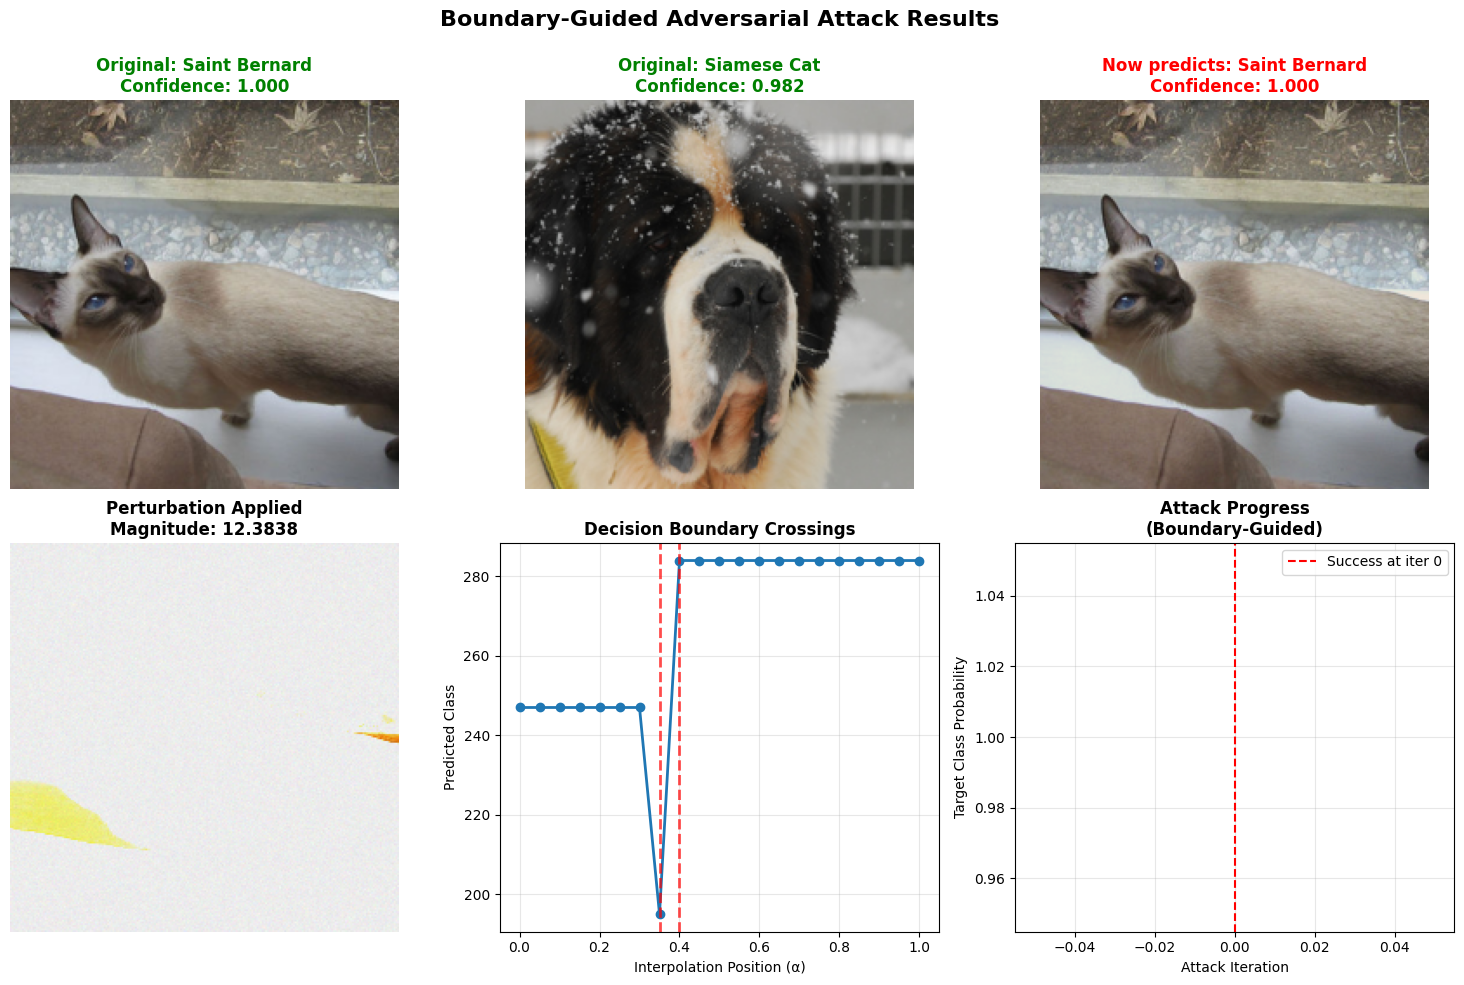

Boundary Directions Used: 3
Total Queries: 70


In [57]:
visualize_adversarial_attack(result, boundary_data, img1, img2, attacker.victim)

/tmp/ipykernel_23958/3937682193.py:30: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/robin/Programming/hiruva/jupyter/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


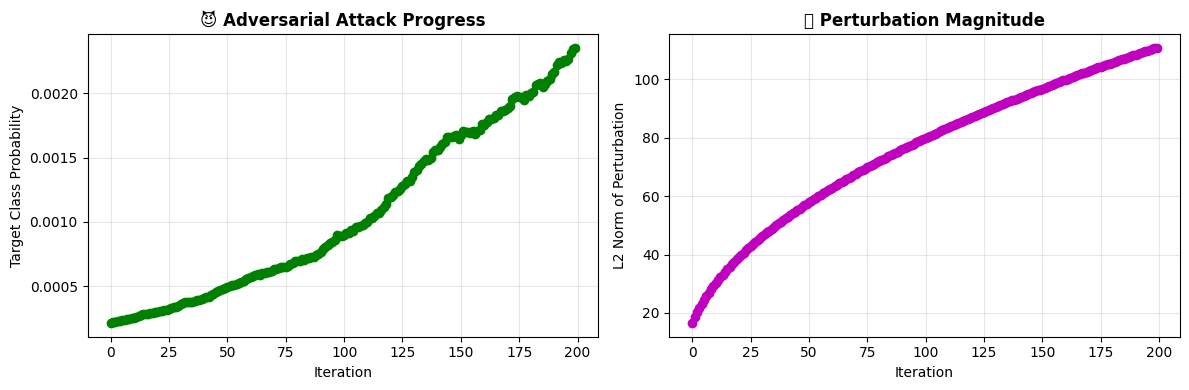


Failed. This shows the model's vulnerability (if any) to small perturbations.


In [58]:
def plot_adversarial_results(adv_result):
    if not adv_result['history']:
        print("No attack history to plot.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    iterations = [h['iteration'] for h in adv_result['history']]
    target_probs = [h['target_probability'] for h in adv_result['history']]
    perturbation_norms = [h['perturbation_norm'] for h in adv_result['history']]
    
    # Plot 1: Attack progress
    ax1.plot(iterations, target_probs, 'go-', markersize=6, linewidth=2)
    ax1.set_title('😈 Adversarial Attack Progress', fontweight='bold')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Target Class Probability')
    ax1.grid(True, alpha=0.3)
    
    if adv_result['success']:
        ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Success Threshold')
        ax1.legend()
    
    # Plot 2: Perturbation magnitude
    ax2.plot(iterations, perturbation_norms, 'mo-', markersize=6, linewidth=2)
    ax2.set_title('🔧 Perturbation Magnitude', fontweight='bold')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('L2 Norm of Perturbation')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_adversarial_results(adv_result)

print(f"\n{'Success!' if adv_result['success'] else 'Failed.'} This shows the model's vulnerability (if any) to small perturbations.")


### Stealing model knowledge

In the next example of an extractive, black box attack, we attempt to reverse engineer a model's decision making progress.

We generate synthetic inputs and get results from the model to collect input-output pairs. We then use these pairs as surrogate data to train a model which mimics the original model's behaviour. 

In [65]:
def steal_model_knowledge(self, n_samples=400):
    """Model extraction attack - steal the victim's knowledge!"""
    print(f"\nATTACK 3: Model Extraction (Knowledge Theft)")
    print(f"  Generating {n_samples} strategic queries to steal model knowledge...")
    
    # Generate diverse synthetic inputs to query the model
    synthetic_inputs = []
    stolen_labels = []
    
    # Strategy: Use different types of inputs to maximize information gain
    for i in range(n_samples):
        if i % 4 == 0:
            # Random noise
            sample = torch.randn(3, 224, 224) * 0.5
        elif i % 4 == 1:
            # Structured patterns
            sample = torch.zeros(3, 224, 224)
            sample[:, :, ::8] = 2.0  # Vertical stripes
        elif i % 4 == 2:
            # Gradients
            x = torch.linspace(-2, 2, 224)
            y = torch.linspace(-2, 2, 224)
            X, Y = torch.meshgrid(x, y, indexing='ij')
            sample = torch.stack([X, Y, X*Y])
        else:
            # High frequency patterns
            sample = torch.randn(3, 224, 224) * 2.0
            sample[:, ::2, ::2] *= 3
        
        # Query the victim model
        probs = self.victim.predict(sample)
        predicted_class = torch.argmax(probs).item()
        
        synthetic_inputs.append(sample.flatten().numpy())
        stolen_labels.append(predicted_class)
    
    # Train our surrogate model on stolen data
    X_stolen = np.array(synthetic_inputs)
    y_stolen = np.array(stolen_labels)
    
    # Check if we got diverse enough data
    unique_classes = len(set(stolen_labels))
    print(f"   Discovered {unique_classes} different classes")
    
    if unique_classes < 2:
        print("   Warning: Low class diversity - model might be too specialized")
        return None
    
    # Train surrogate model
    print("   Training surrogate model on stolen data...")
    surrogate = RandomForestClassifier(n_estimators=50, random_state=42)
    surrogate.fit(X_stolen, y_stolen)
    
    # Evaluate how well we've stolen the knowledge
    train_accuracy = accuracy_score(y_stolen, surrogate.predict(X_stolen))
    
    print(f"   Surrogate model trained!")
    print(f"   Training accuracy: {train_accuracy:.3f}")
    print(f"   Queries used: {n_samples} | Total: {self.victim.queries}")
    
    return {
        'surrogate_model': surrogate,
        'training_data': (X_stolen, y_stolen),
        'accuracy': train_accuracy,
        'classes_discovered': unique_classes
    }

In [66]:
remaining_queries = victim.max_queries - victim.queries
extraction_samples = min(300, remaining_queries - 50)  # Leave buffer
extraction_result = steal_model_knowledge(attacker, extraction_samples)


ATTACK 3: Model Extraction (Knowledge Theft)
  Generating 300 strategic queries to steal model knowledge...
   Discovered 5 different classes
   Training surrogate model on stolen data...
   Surrogate model trained!
   Training accuracy: 1.000
   Queries used: 300 | Total: 970


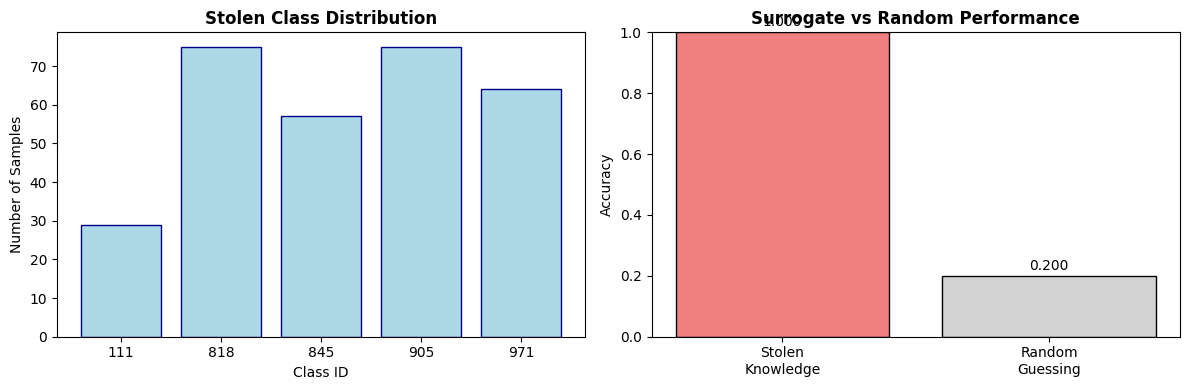


INSIGHT: We successfully stole knowledge from 5 classes!
    Our surrogate model can now mimic the victim's behavior on new inputs.


In [67]:
def plot_extraction_results(extraction_result):
    if extraction_result is None:
        print("No extraction results to plot.")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot 1: Class distribution
    _, y_stolen = extraction_result['training_data']
    unique_classes, counts = np.unique(y_stolen, return_counts=True)
    
    ax1.bar(range(len(unique_classes)), counts, color='lightblue', edgecolor='darkblue')
    ax1.set_title('Stolen Class Distribution', fontweight='bold')
    ax1.set_xlabel('Class ID')
    ax1.set_ylabel('Number of Samples')
    ax1.set_xticks(range(len(unique_classes)))
    ax1.set_xticklabels([f'{c}' for c in unique_classes])
    
    # Plot 2: Model performance comparison
    methods = ['Stolen\nKnowledge', 'Random\nGuessing']
    accuracies = [extraction_result['accuracy'], 1.0/extraction_result['classes_discovered']]
    
    bars = ax2.bar(methods, accuracies, color=['lightcoral', 'lightgray'], edgecolor='black')
    ax2.set_title('Surrogate vs Random Performance', fontweight='bold')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim(0, 1)
    
    # Add value labels
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

if extraction_result:
    plot_extraction_results(extraction_result)
    print(f"\nINSIGHT: We successfully stole knowledge from {extraction_result['classes_discovered']} classes!")
    print("    Our surrogate model can now mimic the victim's behavior on new inputs.")


ATTACK SUMMARY
Total API queries used: 970/10000
Decision boundaries found: 2
Adversarial attack success: ❌
Model extraction accuracy: 1.000
Classes discovered: 5
Estimated attack cost: $0.97


/tmp/ipykernel_23958/2162206100.py:65: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/robin/Programming/hiruva/jupyter/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


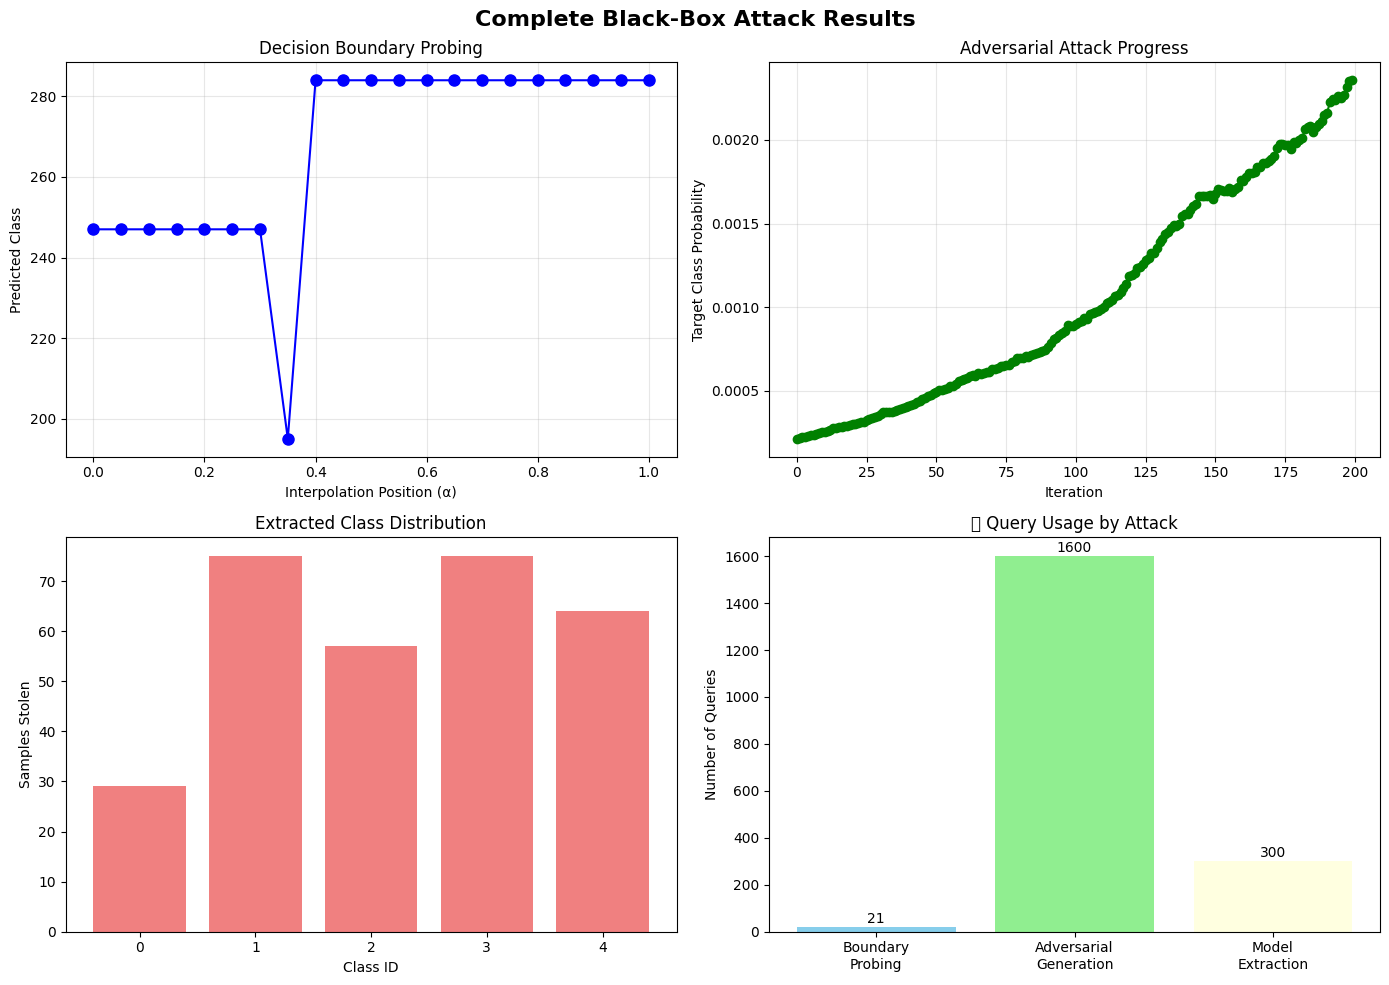

In [68]:
print("ATTACK SUMMARY")

print(f"Total API queries used: {victim.queries}/{victim.max_queries}")
print(f"Decision boundaries found: {len(crossings)}")
print(f"Adversarial attack success: {'✅' if adv_result['success'] else '❌'}")

if extraction_result:
    print(f"Model extraction accuracy: {extraction_result['accuracy']:.3f}")
    print(f"Classes discovered: {extraction_result['classes_discovered']}")

cost_estimate = victim.queries * 0.001  # Assume $0.001 per query
print(f"Estimated attack cost: ${cost_estimate:.2f}")

# Final comprehensive visualization
def plot_complete_attack_summary(boundary_data, adv_result, extraction_result):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Complete Black-Box Attack Results', fontsize=16, fontweight='bold')
    
    # 1. Decision boundary
    positions = [d['position'] for d in boundary_data]
    predictions = [d['prediction'] for d in boundary_data]
    
    axes[0,0].plot(positions, predictions, 'bo-', markersize=8)
    axes[0,0].set_title('Decision Boundary Probing')
    axes[0,0].set_xlabel('Interpolation Position (α)')
    axes[0,0].set_ylabel('Predicted Class')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Adversarial progress
    if adv_result['history']:
        iterations = [h['iteration'] for h in adv_result['history']]
        target_probs = [h['target_probability'] for h in adv_result['history']]
        
        axes[0,1].plot(iterations, target_probs, 'go-', markersize=6)
        axes[0,1].set_title('Adversarial Attack Progress')
        axes[0,1].set_xlabel('Iteration')
        axes[0,1].set_ylabel('Target Class Probability')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Model extraction results
    if extraction_result:
        _, y_stolen = extraction_result['training_data']
        unique_classes, counts = np.unique(y_stolen, return_counts=True)
        
        axes[1,0].bar(range(len(unique_classes)), counts, color='lightcoral')
        axes[1,0].set_title('Extracted Class Distribution')
        axes[1,0].set_xlabel('Class ID')
        axes[1,0].set_ylabel('Samples Stolen')
    
    # 4. Query usage summary
    attack_names = ['Boundary\nProbing', 'Adversarial\nGeneration', 'Model\nExtraction']
    query_counts = [21, len(adv_result['history']) * 8 if adv_result['history'] else 0, 
                   extraction_samples if extraction_result else 0]
    
    bars = axes[1,1].bar(attack_names, query_counts, color=['skyblue', 'lightgreen', 'lightyellow'])
    axes[1,1].set_title('📊 Query Usage by Attack')
    axes[1,1].set_ylabel('Number of Queries')
    
    # Add value labels
    for bar, count in zip(bars, query_counts):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 5,
                      f'{count}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_complete_attack_summary(boundary_data, adv_result, extraction_result)


### Summary

We can elicit behavioural patterns that reveal model decision tendencies, map decision boundaries and find adversarial examples iteratively. Model extraction is possible however can require thousands or more queries so is a resource-intensive process.

Black-box, or unpermissioned probing also has other limitations: since the process cannot access internal representations of the models, it's harder to understand specific model layer behaviours.

### Defences
Some precautions against model, or weights exfiltration, include:

* Rate limiting and query monitoring
* Output perturbation and noise injection
* Differential privacy mechanisms
* Anomalous query pattern detection
* API access logging and analysis